In [1]:
from gensim.models import Word2Vec, KeyedVectors
import os
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
matplotlib.style.use('ggplot')
plt.rcParams['text.usetex']=True
plt.rcParams['text.latex.unicode']=True
from sklearn.decomposition import PCA

from grid_search import senseEmbeddings
import pickle


# embeddings reduction

In [3]:
def shorten(input_file, outputfile):
    ''' function which eliminates non-synsetID containing embeddings from a given file'''
    model = KeyedVectors.load_word2vec_format(input_file, binary=False)
    #filter out senses without synset ID's
    filtered = dict(filter(lambda x: x[0].find("_bn")!=-1 , model.wv.vocab.items()))

    #manual length and size saving
    length, size = len(filtered.keys()), 100

    #mapping helper
    joiner = lambda x: " ".join(map(str, x))

    #writing short embeddings
    with open(output_file, 'w') as emb:
        emb.write(joiner([str(length),str(size)]) + "\n")
        for key in filtered.keys():
            emb.write(joiner([key,
                            joiner(model.wv[key])]) + "\n")


shorten = False
if shorten:
    shorten(input_file = '../resources/embeddings_final_lower.vec',
            outputfile =  '../resources/embeddings_short.vec')


In [4]:
#new shortened embeddings load check
model = KeyedVectors.load_word2vec_format('../resources/embeddings_short.vec', binary=False)
dictionary = list(model.vocab.keys())

In [5]:
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, filename=None):
    '''plotting function used for 2D word embeddings'''
    
    title = 'T-SNE dimensions by related words'
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        label = label.replace("_","\\_")
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=0.7, label=label)
        for i, word in enumerate(words):
            word = " ".join(" ".join(word.split("bn")[:-1]).split("_")[:-1])
            word = word.replace("_","\\_")
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc='best')
    plt.title(title)
    plt.axis('tight')
    plt.xlabel('$x$ t-SNE')
    plt.ylabel('$y$ t-SNE')
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='pdf', bbox_inches='tight')
    plt.show()


def tsne_plot_3d(title, label, embeddings, a=1, filename=None):
    '''plotting function used for 3D word embeddings'''
    
    fig = plt.figure()
    ax = Axes3D(fig)
    colors = cm.rainbow(np.linspace(0, 1, 1))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=colors, alpha=a, label=label)
    plt.legend(loc=4)
    plt.title(title)
    #plt.show()
    
    with open(filename+'.pickle', 'wb') as pickle_file:
        pickle.dump(ax, pickle_file)
#     if filename:
#         plt.savefig(filename, dpi=120, format='png', bbox_inches='tight')

# T-SNE

In [25]:
class TSNE_plot(object):
    '''class used for several types of tsne plots'''
    
    def __init__(self, keys, model):
        self.keys = list(map(lambda x: senseEmbeddings(x, model.vocab)[0], keys))
        self.model = model
        
    def build(self, topn):
        '''builds embeddings and word clusters for top_n words'''
        
        embedding_clusters, word_clusters = [], []
        for word in self.keys:
            embeddings, words = [], []
            for similar_word, _ in self.model.most_similar(word, topn=topn):
                words.append(similar_word)
                embeddings.append(self.model[similar_word])
            embedding_clusters.append(embeddings)
            word_clusters.append(words)
        return word_clusters, np.array(embedding_clusters)
    
    @staticmethod
    def similarwords2D(word_clusters, embedding_clusters, perplexity = 20, n_iter = 5000):
        '''plots simple 2D similar words from embeddings clusters
        args:
            - word_clusters
            - embedding_clusters
            - perplexity (TSNE)
            - n_iter (TSNE)
        '''
        
        n, m, k = embedding_clusters.shape
        tsne_model_en_2d = TSNE(perplexity=perplexity, n_components=2,
                                init='pca', n_iter=n_iter, random_state=42)
        embedding_clusters = embedding_clusters.reshape(n * m, k)
        embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters)).reshape(n, m, 2) 
        return embeddings_en_2d
        
    def similarwords3D(self, perplexity = 20, n_iter = 5000, n_words=None):
        '''plots a 3D similar words TSNE graph from embeddings clusters
        args:
            - perplexity (TSNE)
            - n_iter (TSNE)
            - n_words: int, optional (default: all in vocab)
        '''
        dictionary = list(self.model.vocab)
        limit = len(dictionary)
        
        if n_words:
            limit = n_words
            
        words_wp, embeddings_wp = [], []
        for index, word in enumerate(dictionary):
            embeddings_wp.append(self.model[word])
            words_wp.append(word)
            if index==n_words:
                break
        
        pca_ = PCA(n_components=10)
        embeddings_wp = pca_.fit_transform(embeddings_wp)
        
        tsne_wp_3d = TSNE(perplexity=perplexity, n_components=3, init='pca',
                          n_iter=n_iter, random_state=42, verbose=5)
        embeddings_wp_3d = tsne_wp_3d.fit_transform(embeddings_wp)

        
        return embeddings_wp_3d

In [55]:
keys = ['European' , 'Parliament', 'Holiday', 'Vacation']
Graph = TSNE_plot(keys, model)

## Normal 2D word similarities 

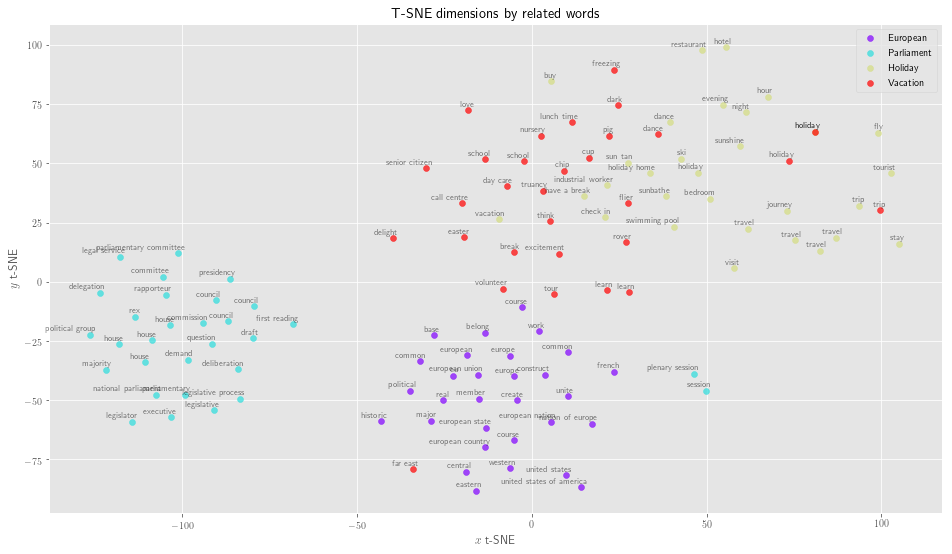

In [31]:
word_clusters, embedding_clusters = Graph.build(topn = 30)
embeddings_en_2d = Graph.similarwords2D(word_clusters, 
                                        embedding_clusters,
                                        perplexity = 20,
                                        n_iter = 5000)

#plotting
tsne_plot_similar_words(keys, embeddings_en_2d, word_clusters, "../report/img/tsne2D.pdf")

# 3D

In [28]:
embeddings_wp_3d = Graph.similarwords3D(perplexity = 3, n_iter = 300, n_words=None)


[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 43134 samples in 0.026s...
[t-SNE] Computed neighbors for 43134 samples in 15.235s...
[t-SNE] Computed conditional probabilities for sample 1000 / 43134
[t-SNE] Computed conditional probabilities for sample 2000 / 43134
[t-SNE] Computed conditional probabilities for sample 3000 / 43134
[t-SNE] Computed conditional probabilities for sample 4000 / 43134
[t-SNE] Computed conditional probabilities for sample 5000 / 43134
[t-SNE] Computed conditional probabilities for sample 6000 / 43134
[t-SNE] Computed conditional probabilities for sample 7000 / 43134
[t-SNE] Computed conditional probabilities for sample 8000 / 43134
[t-SNE] Computed conditional probabilities for sample 9000 / 43134
[t-SNE] Computed conditional probabilities for sample 10000 / 43134
[t-SNE] Computed conditional probabilities for sample 11000 / 43134
[t-SNE] Computed conditional probabilities for sample 12000 / 43134
[t-SNE] Computed conditional probabilities for sa

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/collections.py:902: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


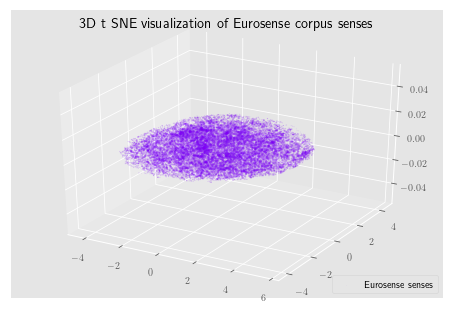

In [29]:
#plotting
tsne_plot_3d('3D t SNE visualization of Eurosense corpus senses',
             'Eurosense senses',
             embeddings_wp_3d,
             a=0.1,
             filename = "../report/img/tsne3D")

In [32]:
# import pickle
# import matplotlib.pyplot as plt

# with open('../report/img/tsne3D.pickle', 'rb') as pickle_file:
#     ax = pickle.load(pickle_file)
# plt.show()